# Surrogate Applications
This noteook's goal is to evaluate the Surrogates under specific conditions, evaluate the sensitivity and prepare plots for the paper.

Table of Contents:
* [Step 1: Import Needed Python Packages and Models](#step1)
* [Step 2: Sensitivity Analysis](#step2)
* [Step 3: Model Preci](#step3)

## Step 1: Import Modules and Models <a class="anchor" id="step1"></a>

In [2]:
# Python Modules
import numpy as np
import pandas as pd
import ipywidgets as widgets

import matplotlib.pyplot as plt
from scipy import integrate, optimize
from tensorflow import keras
import pint
import tensorflow as tf

# Python Modules for Sensitivity Analysis
import shap  # Shapley Analysis
import SALib  # Sobol and PAWN Analysis

from math import log10, floor

In [42]:
# function to round result to significant digits
def round_to_1(x, refx):
    return round(x, -int(floor(log10(abs(refx)))))

In [43]:
# IMPORT NEURAL NETWORK MODELS
bool_reduced = "True"  # False 

## Reduced Models without Mixture
if bool_reduced == True:
    H_model0 = keras.models.load_model("best_model_dndE_CloudTuner.h5")
    H_Emax_model = keras.models.load_model("best_tuned_model_Emax.h5")
    # Status Message
    print("Reduced Models loaded.")
    # File Name Modifier
    file_ex = "reduced"

## Full Models including Mixture
elif bool_reduced == False:
    H_model0 = keras.models.load_model("new_ideal_2.h5")
    H_Emax_model = keras.models.load_model("new_ideal_Emax.h5")
    # Status Message
    print("Full Models loaded.")
    # File Name Modifier
    file_ex = "full"
    

Deuteron And Proton Models loaded.


## Step 2: Sensitivity Analysis <a class="anchor" id="step2"></a>
This part sketches the sensitivity analysis of the Cutoff Energy part of the model. 
We put up a Sobol Indices Analysis joined with a PAWN Analysis and a disjunct Shapley Analysis.
The problem's variables vary according to the selected model, which is incorporated by and elif selection.

In [50]:
from SALib.sample import sobol as sample
from SALib.analyze import sobol as sobol

# Setup the sobol analysis
# Define the model inputs
if bool_reduced == True:
    problem = {
        "num_vars": 7,
        "names": ["EL", "FWHM", "TauL", "Pol", "Theta", "lambda", "dT"],
        "bounds": [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]],  # pol
    }
    # Generate samples
    param_values = sample.sample(problem, 16 * 16384, calc_second_order=True)
    # param_values.shape
    # Round polarization value
    param_values[:, 3] = np.around(param_values[:, 3])
    # Run model
    Y = H_Emax_model(param_values).numpy().flatten()

elif bool_reduced == False:
    problem = {
        "num_vars": 8,
        "names": ["Mix", "EL", "FWHM", "TauL", "Pol", "Theta", "lambda", "dT"],
        "bounds": [
            [0, 1],
            [0, 1],
            [0, 1],
            [0, 1],
            [0, 1],  # pol
            [0, 1],
            [0, 1],
            [0, 1],
        ],
    }

    # Generate samples
    param_values = sample.sample(problem, 16 * 16384, calc_second_order=True)
    # param_values.shape
    # Round polarization value
    param_values[:, 4] = np.around(param_values[:, 4])
    # Run model
    Y = H_Emax_model(param_values).numpy().flatten()

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Print the first-order sensitivity indices
# print(param_values)

              ST   ST_conf
Mix     0.150881  0.002077
EL      0.053563  0.000620
FWHM    0.111876  0.001152
TauL    0.022656  0.000416
Pol     0.042189  0.000458
Theta   0.727916  0.004278
lambda  0.028775  0.000392
dT      0.053421  0.000638
              S1   S1_conf
Mix     0.087434  0.001766
EL      0.035595  0.001201
FWHM    0.075702  0.001902
TauL    0.004076  0.000895
Pol     0.020195  0.001117
Theta   0.618589  0.004046
lambda  0.000846  0.000864
dT      0.026684  0.001338
                       S2   S2_conf
(Mix, EL)        0.000892  0.002336
(Mix, FWHM)      0.003312  0.002427
(Mix, TauL)     -0.000312  0.002290
(Mix, Pol)       0.000957  0.002254
(Mix, Theta)     0.041450  0.002539
(Mix, lambda)    0.000481  0.002408
(Mix, dT)        0.000828  0.002197
(EL, FWHM)      -0.000189  0.001774
(EL, TauL)      -0.000077  0.001704
(EL, Pol)       -0.000256  0.001749
(EL, Theta)      0.001639  0.001660
(EL, lambda)    -0.000039  0.001663
(EL, dT)        -0.000167  0.001711
(FWHM, Tau

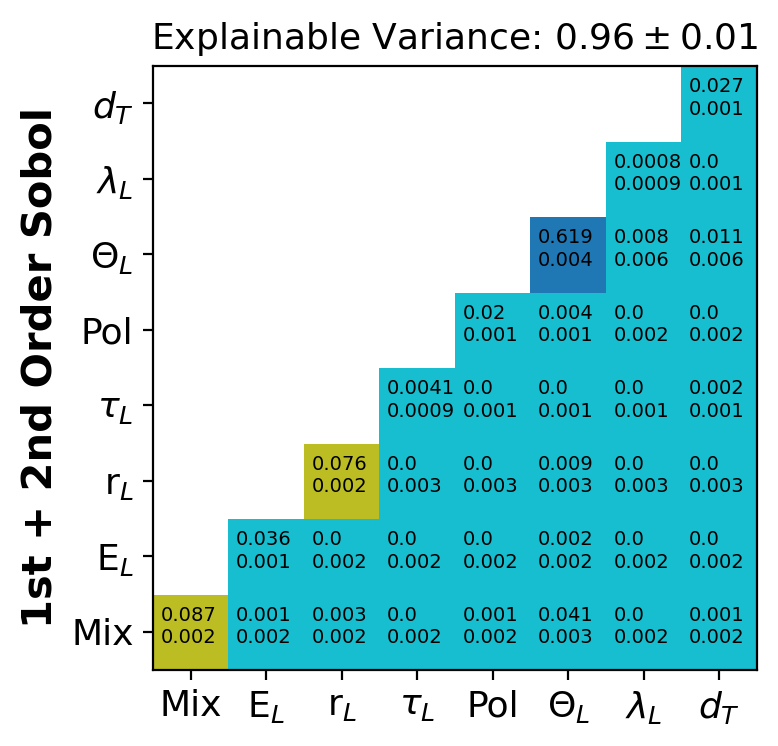

In [53]:
# Plot the second order matrix of Sobol indices
# calculate the mean and sigma for display
sigma = np.zeros(Si["S2"].shape)
mean = np.zeros(Si["S2"].shape)

# Create a new array with first order component on the main axis:
S21value = Si["S2"]
S21sigma = Si["S2_conf"]

## join the main axis:
for i in range(problem["num_vars"]):
    S21value[i][i] = Si["S1"][i]
    S21sigma[i][i] = Si["S1_conf"][i]

# calculate the full explainable variation and its error:
total_vari = np.sum(np.abs(S21value[np.isnan(S21value) == False].flatten()))
total_vari_sigma = np.sqrt(
    np.sum(np.abs(S21sigma[np.isnan(S21sigma) == False].flatten() ** 2))
)
# prepare plotting of the full explanable variation:
plot_total_value = round_to_1(total_vari, total_vari_sigma)
plot_total_sigma = round_to_1(total_vari_sigma, total_vari_sigma)

for i in range(problem["num_vars"]):
    for j in range(problem["num_vars"]):
        if np.isnan(S21value[i, j]) == False:
            sigma[i, j] = round_to_1(S21sigma[i, j], S21sigma[i, j])
            mean[i, j] = round_to_1(S21value[i, j], S21sigma[i, j])

plt.figure(dpi=200)
plt.rcParams["font.size"] = "13"

# set x axis params:
x = [i for i in range(problem["num_vars"])]
y = [i for i in range(problem["num_vars"])]
# step 1: plot the bar chart
plt.imshow(S21value, origin="lower", cmap="tab10_r")
# step 2: plot the errorbar
# plt.errorbar(x, Si['S2'], yerr=Si['S2_conf'], fmt=".", color="r")

# step 3: adjust tick labeling
if bool_reduced == True:
    plot_labels = [
        r"E$_L$",
        r"r$_L$",
        r"$\tau_L$",
        r"Pol",
        r"$\Theta_L$",
        r"$\lambda_L$",
        r"$d_T$",
    ]
elif bool_reduced == False:
    plot_labels = [
        r"Mix",
        r"E$_L$",
        r"r$_L$",
        r"$\tau_L$",
        r"Pol",
        r"$\Theta_L$",
        r"$\lambda_L$",
        r"$d_T$",
    ]

plot_labels = plot_labels[8 - problem["num_vars"] :]
plt.xticks(
    x,
    labels=plot_labels
    # problem['names']
)
plt.yticks(y, labels=plot_labels)
plt.ylabel("1st + 2nd Order Sobol", fontsize=15, weight="bold")
plt.title(
    r"Explainable Variance: $"
    + str(plot_total_value)
    + " \pm "
    + str(plot_total_sigma)
    + "$",
    fontsize=13,
)
for i in range(problem["num_vars"]):
    for j in range(problem["num_vars"]):
        if np.isnan(S21sigma[i, j]) == False:
            labeling = r"$" + str(np.abs(mean[i, j])) + "\pm" + str(sigma[i, j]) + "$"
            labeling = [str(np.abs(mean[i, j])), str(sigma[i, j])]
            plt.text(x[j] - 0.4, y[i] + 0.15, labeling[0], fontsize=7, rotation=0)
            plt.text(x[j] - 0.4, y[i] - 0.15, labeling[1], fontsize=7, rotation=0)

plt.savefig("Sobol_secondOrder_" + file_ex + ".pdf", bbox_inches="tight", pad_inches=0)

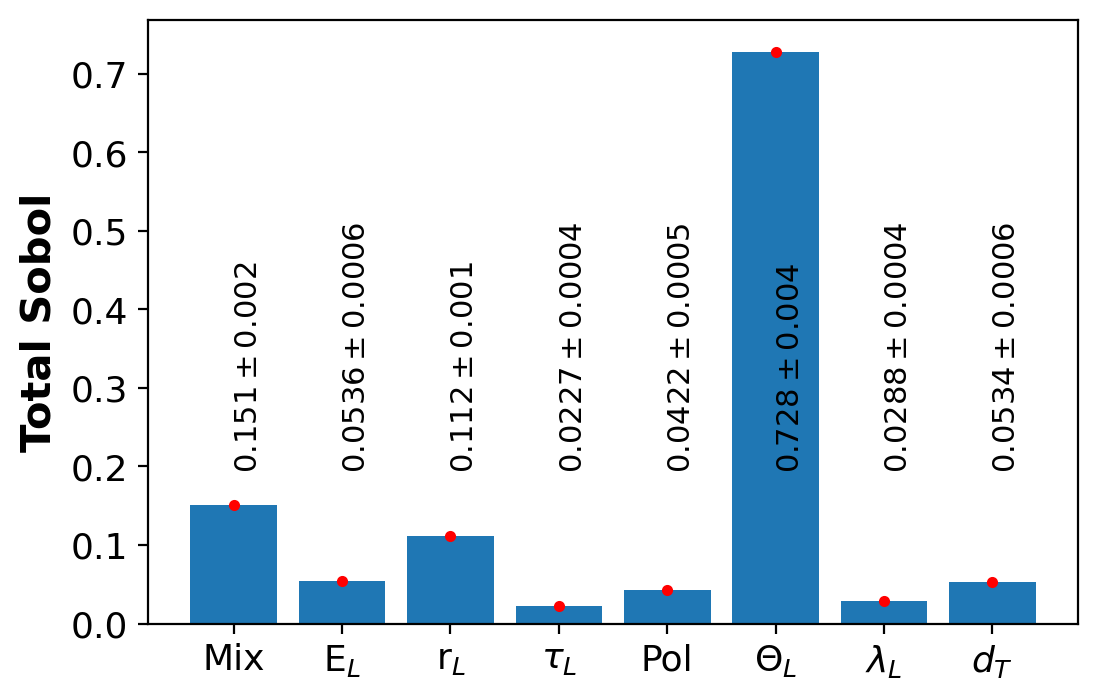

In [54]:
# Plot the total Sobol variation plot.
# calculate the mean and sigma for display
sigma = [round_to_1(Si["ST_conf"][i], Si["ST_conf"][i]) for i in range(problem["num_vars"])]
mean  = [round_to_1(Si["ST"][i], Si["ST_conf"][i]) for i in range(problem["num_vars"])]

plt.figure(dpi=200)
plt.rcParams["font.size"] = "13"

# set x axis params:
x = [i for i in range(problem["num_vars"])]
# step 1: plot the bar chart
plt.bar(x, Si["ST"])
# step 2: plot the errorbar
plt.errorbar(x, Si["ST"], yerr=Si["ST_conf"], fmt=".", color="r")

# step 3: adjust tick labeling
if bool_reduced == True:
    plot_labels = [
        r"E$_L$",
        r"r$_L$",
        r"$\tau_L$",
        r"Pol",
        r"$\Theta_L$",
        r"$\lambda_L$",
        r"$d_T$",
    ]
elif bool_reduced == False:
    plot_labels = [
        r"Mix",
        r"E$_L$",
        r"r$_L$",
        r"$\tau_L$",
        r"Pol",
        r"$\Theta_L$",
        r"$\lambda_L$",
        r"$d_T$",
    ]

plot_labels = plot_labels[8 - problem["num_vars"] :]
plt.xticks(x, labels=plot_labels)
plt.ylabel("Total Sobol", fontsize=15, weight="bold")
for i in range(problem["num_vars"]):
    labeling = r"$" + str(mean[i]) + "\pm" + str(sigma[i]) + "$"
    plt.text(x[i], 0.2, labeling, fontsize=11, rotation=90)


plt.savefig("Sobol_Total_" + file_ex + ".pdf", bbox_inches="tight", pad_inches=0)

In [55]:
from SALib.sample import latin as sample
from SALib.analyze import pawn as pawn

# Setup the PAWN analysis according to
# 10.1016/j.envsoft.2015.01.004

# Generate samples
param_values = sample.sample(problem, 10000)

# param_values = saltelli.sample(problem, 2**12)
# param_values.shape
# Round polarization value
param_values[:, 3] = np.around(param_values[:, 3])
# Run model
Y = H_Emax_model(param_values).numpy().flatten()

# Perform analysis
Si = pawn.analyze(problem, X=param_values, Y=Y, S=200, print_to_console=True)

# Print the first-order sensitivity indices
# print(param_values)

        minimum      mean   median  maximum        CV
Mix      0.0563  0.121276  0.11425   0.2545  0.301859
EL       0.0596  0.166997  0.14220   0.4498  0.468940
FWHM     0.0955  0.263050  0.23610   0.6933  0.448200
TauL     0.0388  0.038800  0.03880   0.0388  0.000000
Pol      0.0614  0.135277  0.12815   0.3154  0.327804
Theta    0.1604  0.418226  0.37295   0.8271  0.403330
lambda   0.0562  0.125980  0.11855   0.2816  0.327963
dT       0.0544  0.136883  0.12195   0.2948  0.375716


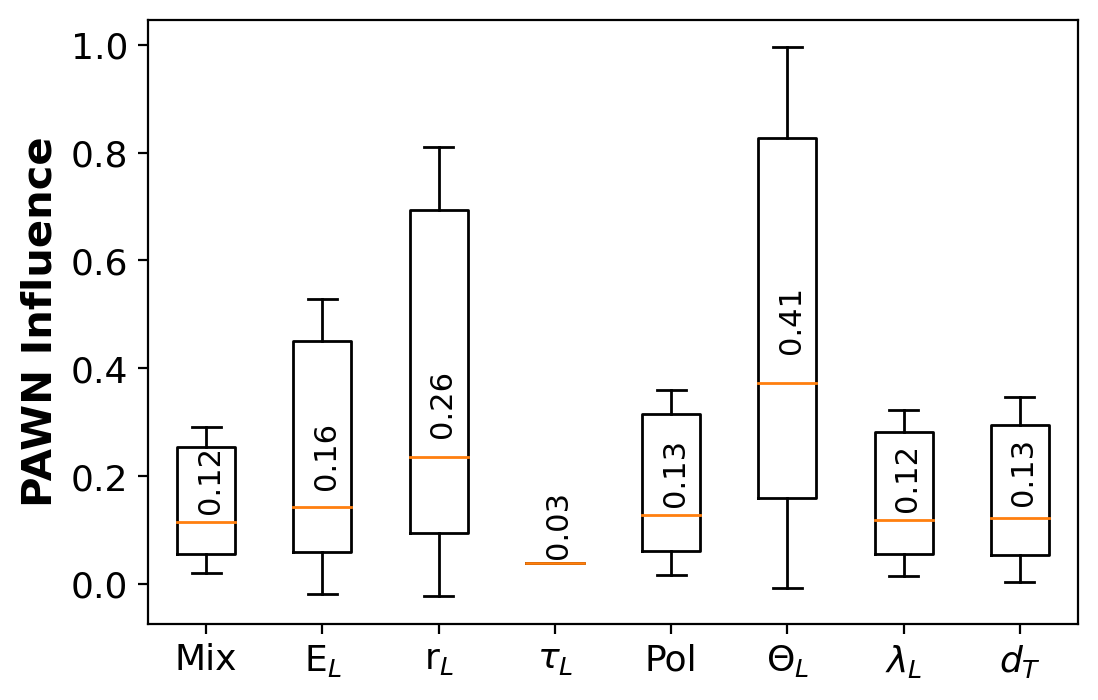

In [56]:
# Plot the PAWN parameters
df = pd.DataFrame(Si)

med = df["median"]
q1 = df["minimum"]
q3 = df["maximum"]
wl = df["minimum"] - df["CV"] * df["mean"]
wh = df["maximum"] + df["CV"] * df["mean"]


stats = [
    {
        "med": med.iloc[i],
        "q1": q1.iloc[i],
        "q3": q3.iloc[i],
        "whislo": wl.iloc[i],
        "whishi": wh.iloc[i],
        "mean": df["mean"].iloc[i],
    }
    for i in range(problem["num_vars"])
]

_, ax = plt.subplots(dpi=200)
ax.bxp(stats, showfliers=False, meanline=True)
plt.rcParams["font.size"] = "13"
# set x axis params:
x = [i for i in range(1, problem["num_vars"] + 1)]
# step 3: adjust tick labeling
plt.xticks(x, labels=plot_labels)
plt.ylabel("PAWN Influence", fontsize=15, weight="bold")

# plot median values
for i in range(problem["num_vars"]):
    labeling = str(np.floor(df["mean"].iloc[i] * 100) / 100)
    plt.text(i + 0.91, df["mean"].iloc[i] + 0.02, labeling, fontsize=11, rotation=90)

plt.savefig("PAWN_" + file_ex + ".pdf", bbox_inches="tight", pad_inches=0)

## Step 3: Model Plots <a class="anchor" id="step3"></a>

In [15]:
# 
inputs0red = np.array(
    [
        [
            30 / 50,
            20e-6
            / 20e-6,  # FWHM of focus spot estimated from G .Claps et al 2020 JINST 15 C02006
            30e-15 / 150e-15,
            1,
            12.2 / 85.0,
            800e-9 / 1100e-9,
            2e-6 / 3e-6,
        ]
    ]
)
inputs0full = np.array(
    [
        [
            0.5,
            30 / 50,
            20e-6
            / 20e-6,  # FWHM of focus spot estimated from G .Claps et al 2020 JINST 15 C02006
            30e-15 / 150e-15,
            1,
            12.2 / 85.0,
            800e-9 / 1100e-9,
            2e-6 / 3e-6,
        ]
    ]
)
# data sets for the maximum proton energy conversion
inputsCmaxfull = np.array(
    [
        [
            0.5,
            1.4 / 50,
            2e-6
            / 20e-6,  # FWHM of focus spot estimated from G .Claps et al 2020 JINST 15 C02006
            137.6e-15 / 150e-15,
            1,
            29.3 / 85.0,
            800e-9 / 1100e-9,
            3e-6 / 3e-6,
        ]
    ]
)


## definition of a wrapper around the model to ease the usage. 
def create_data(spectral_model, cutoff_model, inputs):
    """
    Creates the full spectrum. The relevant model pair has to be passed.
    """

    def model(x):
        return (
            spectral_model(np.insert(inputs, 0, x).reshape((1, inputs.shape[1] + 1)))
            .numpy()
            .flatten()
        )

    model = np.vectorize(model)
    Emax = cutoff_model(inputs).numpy().flatten()[0]
    return model, Emax

In [20]:
# predictions:
## Reduced Model

# dndE, Emax = create_data(spectral_model=H_model0, cutoff_model=H_Emax_model, inputs=inputs0red)
# with this cell, the data below can be created, the reduced model has to loaded though.

In [21]:
# Cached Data for the corresponding spectrum for the reduced model. 
X0 = np.array(
    [   0.0,
        0.06918616,
        0.13837232,
        0.20755847,
        0.27674463,
        0.34593079,
        0.41511695,
        0.48430311,
        0.55348926,
        0.62267542,
        0.69186158,
        0.76104774,
        0.83023389,
        0.89942005,
        0.96860621,
        1.03779237,
        1.10697853,
        1.17616468,
        1.24535084,
        1.314537,
        1.38372316,
        1.45290932,
        1.52209547,
        1.59128163,
        1.66046779,
        1.72965395,
        1.79884011,
        1.86802626,
        1.93721242,
        2.00639858,
        2.07558474,
        2.1447709,
        2.21395705,
        2.28314321,
        2.35232937,
        2.42151553,
        2.49070168,
        2.55988784,
        2.629074,
        2.69826016,
        2.76744632,
        2.83663247,
        2.90581863,
        2.97500479,
        3.04419095,
        3.11337711,
        3.18256326,
        3.25174942,
        3.32093558,
        3.39012174,
        3.4593079,
        3.52849405,
        3.59768021,
        3.66686637,
        3.73605253,
        3.80523869,
        3.87442484,
        3.943611,
        4.01279716,
        4.08198332,
        4.15116947,
        4.22035563,
        4.28954179,
        4.35872795,
        4.42791411,
        4.49710026,
        4.56628642,
        4.63547258,
        4.70465874,
        4.7738449,
        4.84303105,
        4.91221721,
        4.98140337,
        5.05058953,
        5.11977569,
        5.18896184,
        5.258148,
        5.32733416,
        5.39652032,
        5.46570648,
        5.53489263,
        5.60407879,
        5.67326495,
        5.74245111,
        5.81163726,
        5.88082342,
        5.95000958,
        6.01919574,
        6.0883819,
        6.15756805,
        6.22675421,
        6.29594037,
        6.36512653,
        6.43431269,
        6.50349884,
        6.572685,
        6.64187116,
        6.71105732,
        6.78024348,
        6.84942963,
        6.91861579,
        6.98780195,
        7.05698811,
        7.12617427,
        7.19536042,
        7.26454658,
        7.33373274,
        7.4029189,
        7.47210505,
        7.54129121,
        7.61047737,
        7.67966353,
        7.74884969,
        7.81803584,
        7.887222,
        7.95640816,
        8.02559432,
        8.09478048,
        8.16396663,
        8.23315279,
        8.30233895,
        8.37152511,
        8.44071127,
        8.50989742,
        8.57908358,
        8.64826974,
        8.7174559,
        8.78664206,
        8.85582821,
        8.92501437,
        8.99420053,
        9.06338669,
        9.13257284,
        9.201759,
        9.27094516,
        9.34013132,
        9.40931748,
        9.47850363,
        9.54768979,
        9.61687595,
        9.68606211,
        9.75524827,
        9.82443442,
        9.89362058,
        9.96280674,
        10.0319929,
        10.10117906,
        10.17036521,
        10.23955137,
        10.30873753,
        10.37792369,
        10.44710985,
        10.516296,
        10.58548216,
        10.65466832,
        10.72385448,
        10.79304063,
        10.86222679,
        10.93141295,
        11.00059911,
        11.06978527,
        11.13897142,
        11.20815758,
        11.27734374,
        11.3465299,
        11.41571606,
        11.48490221,
        11.55408837,
        11.62327453,
        11.69246069,
        11.76164685,
        11.830833,
        11.90001916,
        11.96920532,
        12.03839148,
        12.10757764,
        12.17676379,
        12.24594995,
        12.31513611,
        12.38432227,
        12.45350842,
        12.52269458,
        12.59188074,
        12.6610669,
        12.73025306,
        12.79943921,
        12.86862537,
        12.93781153,
        13.00699769,
        13.07618385,
        13.14537,
        13.21455616,
        13.28374232,
        13.35292848,
        13.42211464,
        13.49130079,
        13.56048695,
        13.62967311,
        13.69885927,
        13.76804543,
    ]
)
Y0 = np.array(
    [   53.641518,
        52.063786,
        51.805275,
        51.68953,
        51.624542,
        51.568398,
        51.525063,
        51.367813,
        51.23494,
        51.12079,
        51.030083,
        50.930084,
        50.831364,
        50.74602,
        50.668667,
        50.551987,
        50.438393,
        50.350067,
        50.29706,
        50.24009,
        50.18079,
        50.121746,
        50.06446,
        50.020916,
        49.983227,
        49.944405,
        49.905582,
        49.86806,
        49.832245,
        49.797653,
        49.76306,
        49.72847,
        49.67878,
        49.620617,
        49.556347,
        49.494965,
        49.448647,
        49.402588,
        49.361618,
        49.32065,
        49.278587,
        49.235405,
        49.18862,
        49.14185,
        49.095066,
        49.048294,
        48.997498,
        48.94455,
        48.891598,
        48.840084,
        48.789116,
        48.72768,
        48.661655,
        48.59776,
        48.5369,
        48.48191,
        48.426914,
        48.371925,
        48.316933,
        48.26194,
        48.206947,
        48.151955,
        48.09591,
        48.039818,
        47.98368,
        47.926544,
        47.86941,
        47.81688,
        47.77289,
        47.7289,
        47.684917,
        47.639153,
        47.59011,
        47.54107,
        47.492035,
        47.442993,
        47.393948,
        47.34491,
        47.29587,
        47.246834,
        47.197792,
        47.14875,
        47.090363,
        47.035065,
        46.986008,
        46.93696,
        46.887905,
        46.838852,
        46.7898,
        46.74537,
        46.74077,
        46.752293,
        46.829937,
        46.925797,
        47.02166,
        47.115555,
        47.19532,
        47.266865,
        47.36065,
        47.455235,
        47.55119,
        47.646793,
        47.715645,
        47.782463,
        47.849277,
        47.91472,
        47.979584,
        48.030594,
        48.04016,
        48.049717,
        48.059578,
        48.072723,
        48.0868,
        48.100697,
        48.114525,
        48.11756,
        48.118916,
        48.120277,
        48.121365,
        48.12146,
        48.12155,
        48.121716,
        48.122406,
        48.1231,
        48.123787,
        48.124474,
        48.125168,
        48.105633,
        48.065464,
        48.019707,
        47.97395,
        47.928093,
        47.88156,
        47.83504,
        47.788517,
        47.741993,
        47.699974,
        47.658054,
        47.616436,
        47.574986,
        47.533382,
        47.491776,
        47.45469,
        47.41684,
        47.402363,
        47.385235,
        47.36811,
        47.355194,
        47.344223,
        47.319374,
        47.294777,
        47.270256,
        47.245735,
        47.221214,
        47.196693,
        47.172173,
        47.14161,
        47.114365,
        47.09504,
        47.075714,
        47.056396,
        47.037067,
        47.017746,
        46.99842,
        46.979095,
        46.95977,
        46.940453,
        46.923126,
        46.906925,
        46.891792,
        46.886246,
        46.880966,
        46.87569,
        46.870415,
        46.86513,
        46.859215,
        46.85321,
        46.847202,
        46.851936,
        46.86798,
        46.884026,
        46.900032,
        46.915825,
        46.926323,
        46.93326,
        46.940193,
        46.94713,
        46.954056,
        46.960995,
        46.968666,
        46.97671,
        46.97992,
        46.97793,
        46.97594,
        46.973953,
        46.97197,
        46.96998,
        46.973,
        46.976036,
        46.979073,
    ]
)

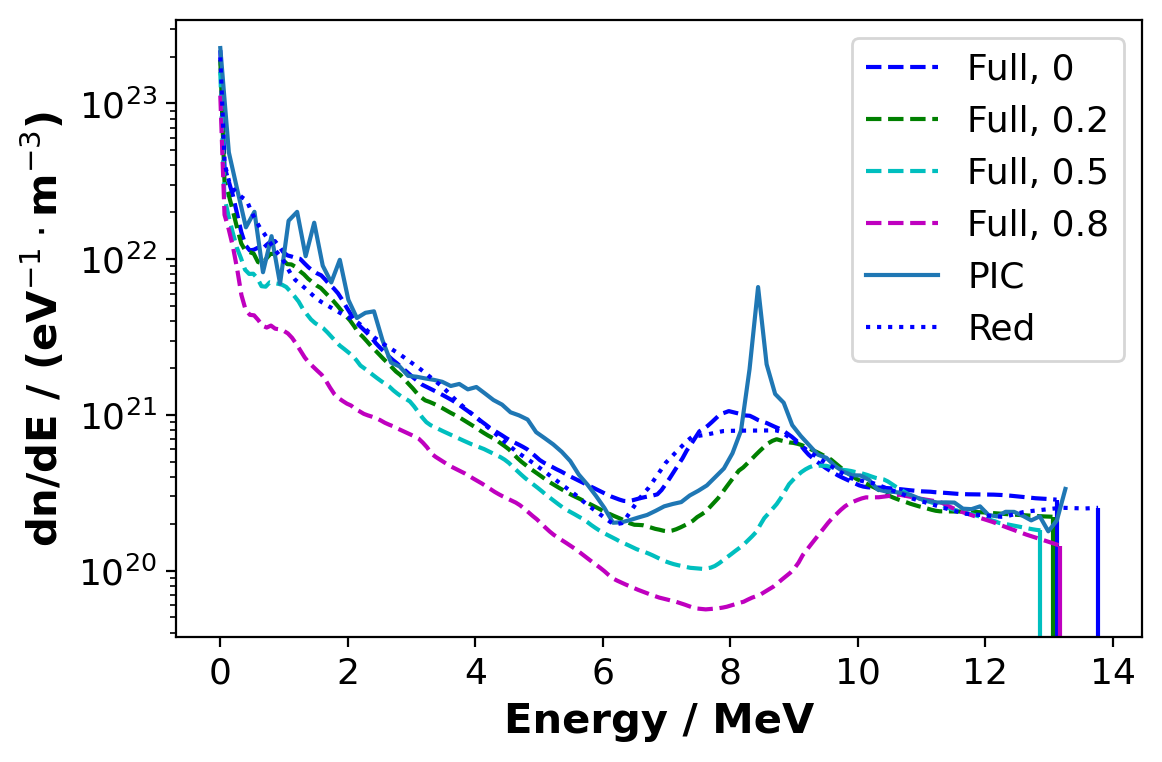

In [27]:
# plotting:
vega_init_sim = np.load("vega_init_h.npy")

# colorlist
cl = ["b", "g", "c", "m", "y", "k"]

plt.figure(dpi=200)
plt.rcParams["font.size"] = "13"
x_sim = np.linspace(0, 1, 100)

n = 0
# loop over mixture:
for i in [0, 0.2, 0.5, 0.8]:
    inputs0full[0][0] = i
    dndE, Emax = create_data(
        spectral_model=H_model0, cutoff_model=H_Emax_model, inputs=inputs0full
    )
    x = np.linspace(0, Emax, 200)
    plt.plot(x, np.exp(dndE(x)), "--" + cl[n], label="Full, " + str(i))
    plt.vlines(Emax, ymin=0, ymax=np.exp(dndE(Emax)), colors=cl[n])

    n = n + 1

plt.plot(x_sim * vega_init_sim[-1], np.exp(vega_init_sim[:-1]), label="PIC")
plt.plot(X0, np.exp(Y0), ":" + cl[0], label="Red")
plt.vlines(X0[-1], ymin=0, ymax=np.exp(Y0[-1]), colors=cl[0])
# plt.vlines(Emax, ymin=0, ymax=np.exp(dndE(Emax)))
# plt.vlines(vega_init_sim[-1], ymin=0, ymax=np.exp(vega_init_sim[-2]))
plt.legend()
plt.yscale("log")
plt.ylabel("dn/dE / (eV$^{-1}\cdot$m$^{-3}$)", fontsize=15, weight="bold")
plt.xlabel("Energy / MeV", fontsize=15, weight="bold")
# plt.title("Predicted Energy Spectrum - Accelerated Hydrogen Ions")
plt.tight_layout()
# plt.show
plt.savefig("Spectrum_comparison.pdf", bbox_inches="tight", pad_inches=0)

# x_init = x
# init_model_pred = np.exp(H_model(x))